# Pixel induced current
In this notebook we load a track dataset and we calculate the current induced on the pixels placed at the anode.

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import detsim

import importlib
importlib.reload(detsim)
from larndsim import consts, quenching, drifting
importlib.reload(drifting)
importlib.reload(quenching)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

import pickle
import numpy as np
import numba as nb
from tqdm import tqdm_notebook as progress_bar
import pandas as pd

Here we load the dataset with the tracks and we store the column cols corresponding to the each variable.

In [3]:
tracks = pickle.load(open('edepsimDataset.p', 'rb'))
tracks = pd.DataFrame.from_dict(tracks)
tracks['t'] = 0.
tracks['t_start'] = 0.
tracks['t_end'] = 0.
tracks['x_start'] /= 1e2
tracks['y_start'] /= 1e2
tracks['z_start'] /= 1e2
tracks['x_end'] /= 1e2
tracks['y_end'] /= 1e2
tracks['z_end'] /= 1e2
tracks['dx'] = np.sqrt(pow(tracks['x_end']-tracks['x_start'], 2) +
                    pow(tracks['y_end']-tracks['y_start'], 2) +
                    pow(tracks['z_end']-tracks['z_start'], 2))
tracks['x'] = (tracks['x_end']+tracks['x_start'])/2
tracks['y'] = (tracks['y_end']+tracks['y_start'])/2
tracks['z'] = (tracks['z_end']+tracks['z_start'])/2
tracks['dE'] = np.abs(tracks['dE'])*1e3
tracks['dEdx'] = tracks['dE']/tracks['dx']
tracks['NElectrons'] = 0.
tracks['longDiff'] = 0.
tracks['tranDiff'] = 0.

Here we pass our columnar data through the quenching and drifting stages, so we calculate the amount of electrons that reach the anode.

In [4]:
tracks_np = tracks.to_numpy()
cols = nb.typed.Dict()
for i, c, in enumerate(tracks.columns):
    cols[c] = i

In [5]:
quenching.Quench(tracks_np, cols, mode="box")

In [6]:
drifting.Drift(tracks_np, cols)

In [7]:
selectedTracks = tracks_np[:100]

Here we instantiate a TPC class with a determined number of pixels per axis and a determined sampling in time.

In [8]:
tpc = detsim.TPC(cols, t_sampling=0.5, n_pixels=400)

## Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [9]:
for t in progress_bar(selectedTracks, desc='Processing tracks...'):
    img = tpc.calculate_current(t)

## Track and pixel display
Here we show the selected tracks and the pixels affected by them. The color of the pixel correspond to the integrated induced current.

(-7.0, 7.0)

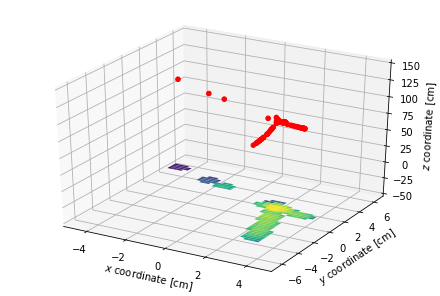

In [10]:
%matplotlib inline
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

currents = np.array([sum(tpc.pixel_response(p)) for p in tpc.active_pixels])
norm = mpl.colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)


for i,p in enumerate(list(tpc.active_pixels.keys())):
    rect = plt.Rectangle((p[0]*tpc.x_pixel_size+consts.tpcBorders[0][0],
                          p[1]*tpc.y_pixel_size+consts.tpcBorders[1][0]),
                         tpc.x_pixel_size,tpc.y_pixel_size,
                         linewidth=0,
                         edgecolor='grey', 
                         facecolor=m.to_rgba(currents[i]), label='Pixel')
    ax.add_patch(rect)
    art3d.pathpatch_2d_to_3d(rect, z=-50, zdir="z")
    
for t in selectedTracks:
    ax.plot((t[cols['x_start']], t[cols['x_end']]), 
            (t[cols['y_start']], t[cols['y_end']]),
            (t[cols['z_start']], t[cols['z_end']]),
            c='r',
            zorder=99999)
    ax.scatter((t[cols['x_start']], t[cols['x_end']]), 
               (t[cols['y_start']], t[cols['y_end']]),
               (t[cols['z_start']], t[cols['z_end']]),
               c='r')

ax.set_xlabel("$x$ coordinate [cm]")
ax.set_ylabel("$y$ coordinate [cm]")
ax.set_zlabel("$z$ coordinate [cm]")
ax.set_zlim3d(-50,150)
ax.set_xlim3d(-5,5)
ax.set_ylim3d(-7,7)

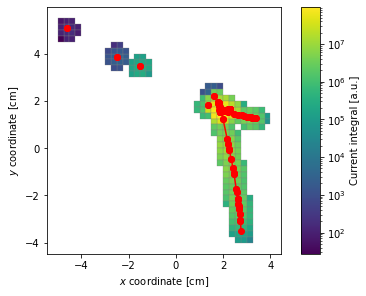

In [11]:
%matplotlib inline
fig,ax = plt.subplots(1,1, constrained_layout=True)
currents = np.array([sum(tpc.pixel_response(p)) for p in tpc.active_pixels])

for i,p in enumerate(list(tpc.active_pixels.keys())):
    if currents[i]:
        rect = plt.Rectangle((p[0]*tpc.x_pixel_size+consts.tpcBorders[0][0],
                              p[1]*tpc.y_pixel_size+consts.tpcBorders[1][0]),
                             tpc.x_pixel_size,tpc.y_pixel_size,
                             linewidth=0.3,
                             edgecolor='grey', 
                             facecolor=m.to_rgba(currents[i]), label='Pixel')
        ax.add_patch(rect)
    
for t in selectedTracks:
    ax.plot((t[cols['x_start']], t[cols['x_end']]), 
            (t[cols['y_start']], t[cols['y_end']]),
            c='r',
            zorder=10)
    ax.scatter((t[cols['x_start']], t[cols['x_end']]), 
               (t[cols['y_start']], t[cols['y_end']]),
               c='r',
               zorder=10)
# ax.set_xlim(0,5)
# ax.set_ylim(-7,2)
ax.set_xlabel("$x$ coordinate [cm]")
ax.set_ylabel("$y$ coordinate [cm]")
ax.set_aspect("equal")
_ = plt.colorbar(m,fraction=0.046, pad=0.04, label='Current integral [a.u.]')

Text(0, 0.5, 'Current [a.u.]')

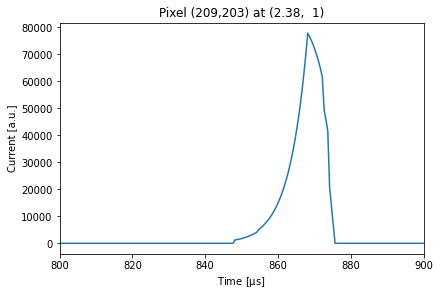

In [12]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
pixelID = tpc.pixel_from_coordinates(2.14,0.84)
current = tpc.pixel_response(pixelID)
ax.plot(tpc.anode_t, current, label='Current')
ax.set_xlim(800,900)  
ax.set_title("Pixel (%i,%i) at (%.2f, %2.f)" % (pixelID[0], pixelID[1], 
                                      (pixelID[0] + 0.5)*tpc.x_pixel_size+consts.tpcBorders[0][0], 
                                      (pixelID[1] + 0.5)*tpc.y_pixel_size+consts.tpcBorders[1][0]))
ax.set_xlabel("Time [$\mathrm{\mu}$s]")
ax.set_ylabel("Current [a.u.]")
# ax.set_yscale("log")
# ax.set_ylim(1,1e7)